In [1]:
import os

os.chdir('..')

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Leitura de Dados

In [3]:
DATA_DIR = 'assets/wind.csv'

In [4]:
data = pd.read_csv(DATA_DIR)
data = data.drop('rec_fcast', axis=1)
data['datetime'] = pd.to_datetime(data['datetime'], dayfirst=True)

data.set_index('datetime', inplace=True)

data['normalized_wp'] = data['wpower'] / data['capacity']

subset_year = [2013 < x < 2018 for x in data.index.year]

data = data.loc[subset_year, :]

data = data.ffill()
data = data.resample('H').mean().ffill()

series = data['normalized_wp']

thr = 0.1

series.iloc[np.where(series > 1)] = np.nan
series = series.ffill()

series.head()

/var/folders/4r/ptn78qsx2vgffms1_tb7v9xw0000gn/T/ipykernel_15433/2659647096.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('H').mean().ffill()


datetime
2014-01-01 00:00:00    0.534434
2014-01-01 01:00:00    0.516926
2014-01-01 02:00:00    0.556381
2014-01-01 03:00:00    0.546214
2014-01-01 04:00:00    0.613959
Freq: h, Name: normalized_wp, dtype: float64

In [5]:
series.shape

(35064,)

<Axes: xlabel='datetime'>

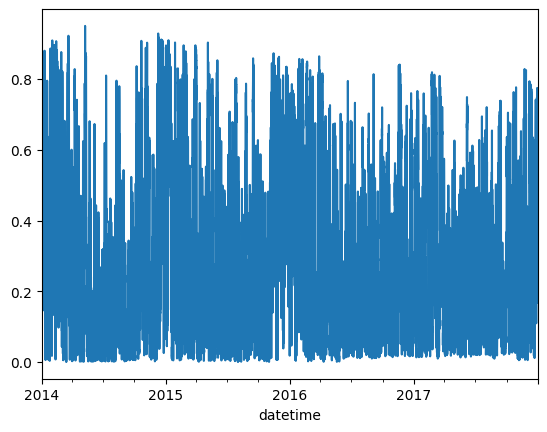

In [6]:
series.plot()

<Axes: xlabel='datetime'>

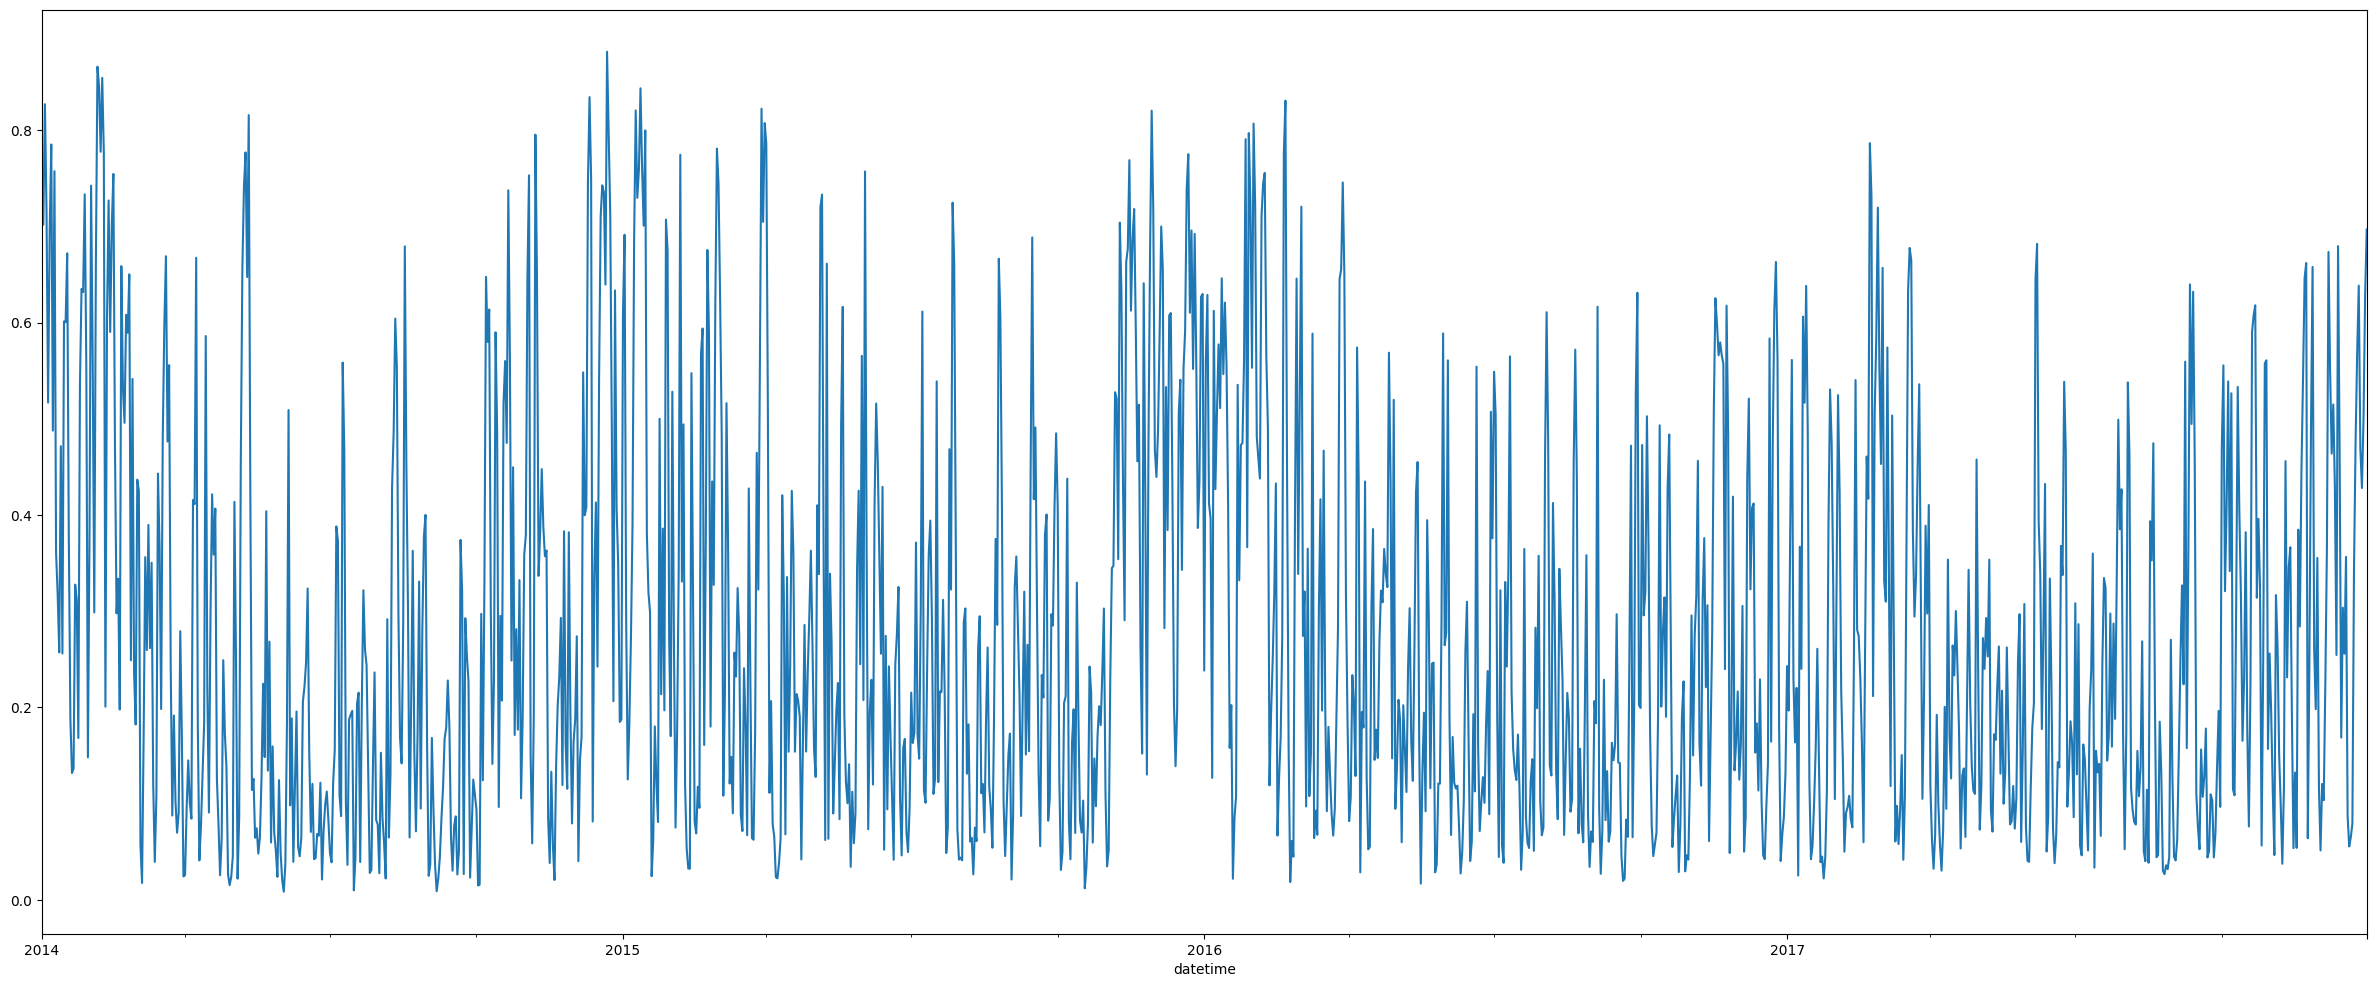

In [7]:
series.resample('D').mean().plot(figsize=(30, 12))

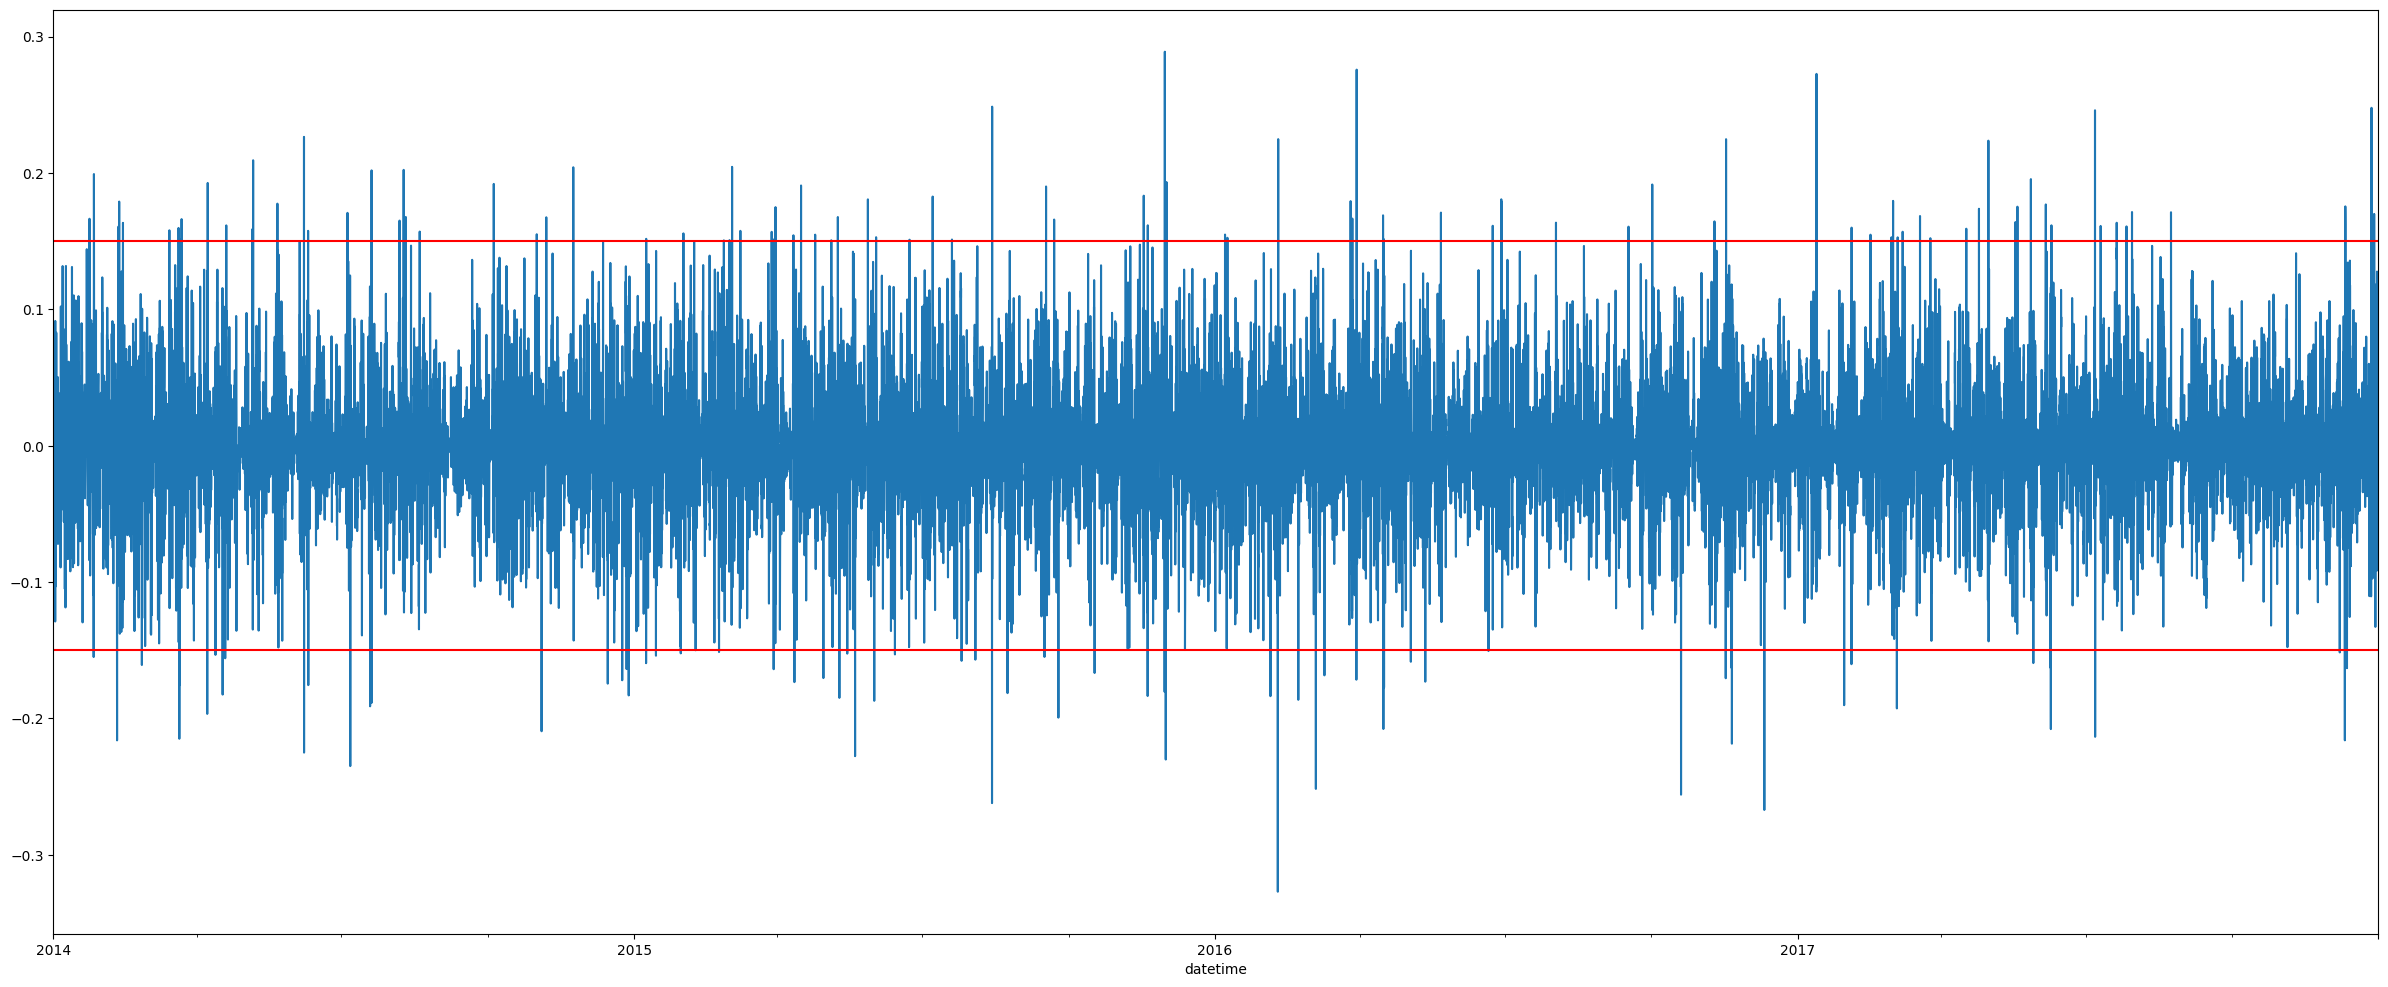

In [8]:
thr = 0.15

series.diff().plot(figsize=(30, 12))
plt.axhline(y = thr, color = 'r')
plt.axhline(y = -thr, color = 'r')

### Construindo um modelo preditivo

In [9]:
from sklearn.model_selection import train_test_split
from src.tde import time_delay_embedding

series.head()

datetime
2014-01-01 00:00:00    0.534434
2014-01-01 01:00:00    0.516926
2014-01-01 02:00:00    0.556381
2014-01-01 03:00:00    0.546214
2014-01-01 04:00:00    0.613959
Freq: h, Name: normalized_wp, dtype: float64

In [10]:
train, test = train_test_split(series, test_size=0.3, shuffle=False)

train_df = time_delay_embedding(train, n_lags=24, horizon=1).dropna()
test_df = time_delay_embedding(test, n_lags=24, horizon=1).dropna()

train_df.head()

,t-23,t-22,t-21,t-20,t-19,t-18,t-17,t-16,t-15,t-14,...,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t-0,t+1
datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-02 00:00:00,0.534434,0.516926,0.556381,0.546214,0.613959,0.663075,0.707659,0.730058,0.711570,0.732158,...,0.838919,0.867145,0.853586,0.868148,0.869592,0.858556,0.868214,0.859637,0.874104,0.872159
2014-01-02 01:00:00,0.516926,0.556381,0.546214,0.613959,0.663075,0.707659,0.730058,0.711570,0.732158,0.776283,...,0.867145,0.853586,0.868148,0.869592,0.858556,0.868214,0.859637,0.874104,0.872159,0.882175
2014-01-02 02:00:00,0.556381,0.546214,0.613959,0.663075,0.707659,0.730058,0.711570,0.732158,0.776283,0.782751,...,0.853586,0.868148,0.869592,0.858556,0.868214,0.859637,0.874104,0.872159,0.882175,0.866289
2014-01-02 03:00:00,0.546214,0.613959,0.663075,0.707659,0.730058,0.711570,0.732158,0.776283,0.782751,0.797705,...,0.868148,0.869592,0.858556,0.868214,0.859637,0.874104,0.872159,0.882175,0.866289,0.839416
2014-01-02 04:00:00,0.613959,0.663075,0.707659,0.730058,0.711570,0.732158,0.776283,0.782751,0.797705,0.817610,...,0.869592,0.858556,0.868214,0.859637,0.874104,0.872159,0.882175,0.866289,0.839416,0.710533


In [11]:
X_train = train_df.drop('t+1', axis=1)
X_test = test_df.drop('t+1', axis=1)

print(X_train.head())

train_exc = (train_df['t+1'] - train_df['t-0']).abs() > thr
y_train_01 = train_exc.astype(int)

test_exc = (test_df['t+1'] - test_df['t-0']).abs() > thr
y_test_01 = test_exc.astype(int)

y_train_01

                         t-23      t-22      t-21      t-20      t-19  \
datetime                                                                
2014-01-02 00:00:00  0.534434  0.516926  0.556381  0.546214  0.613959   
2014-01-02 01:00:00  0.516926  0.556381  0.546214  0.613959  0.663075   
2014-01-02 02:00:00  0.556381  0.546214  0.613959  0.663075  0.707659   
2014-01-02 03:00:00  0.546214  0.613959  0.663075  0.707659  0.730058   
2014-01-02 04:00:00  0.613959  0.663075  0.707659  0.730058  0.711570   

                         t-18      t-17      t-16      t-15      t-14  ...  \
datetime                                                               ...   
2014-01-02 00:00:00  0.663075  0.707659  0.730058  0.711570  0.732158  ...   
2014-01-02 01:00:00  0.707659  0.730058  0.711570  0.732158  0.776283  ...   
2014-01-02 02:00:00  0.730058  0.711570  0.732158  0.776283  0.782751  ...   
2014-01-02 03:00:00  0.711570  0.732158  0.776283  0.782751  0.797705  ...   
2014-01-02 04:00:00 

datetime
2014-01-02 00:00:00    0
2014-01-02 01:00:00    0
2014-01-02 02:00:00    0
2014-01-02 03:00:00    0
2014-01-02 04:00:00    0
                      ..
2016-10-19 11:00:00    0
2016-10-19 12:00:00    0
2016-10-19 13:00:00    0
2016-10-19 14:00:00    0
2016-10-19 15:00:00    0
Freq: h, Length: 24520, dtype: int64

In [12]:
y_train_01.value_counts(normalize=True)

0    0.994902
1    0.005098
Name: proportion, dtype: float64

In [13]:
y_test_01.value_counts(normalize=True)

0    0.995522
1    0.004478
Name: proportion, dtype: float64

<Axes: >

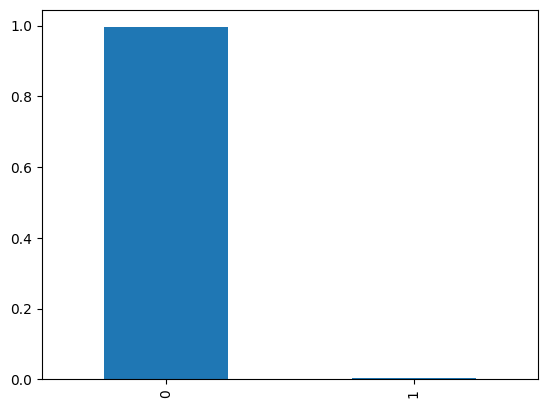

In [14]:
y_train_01.value_counts(normalize=True).plot.bar()

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model = RandomForestClassifier()
model.fit(X_train, y_train_01)

RandomForestClassifier()

<Axes: xlabel='datetime'>

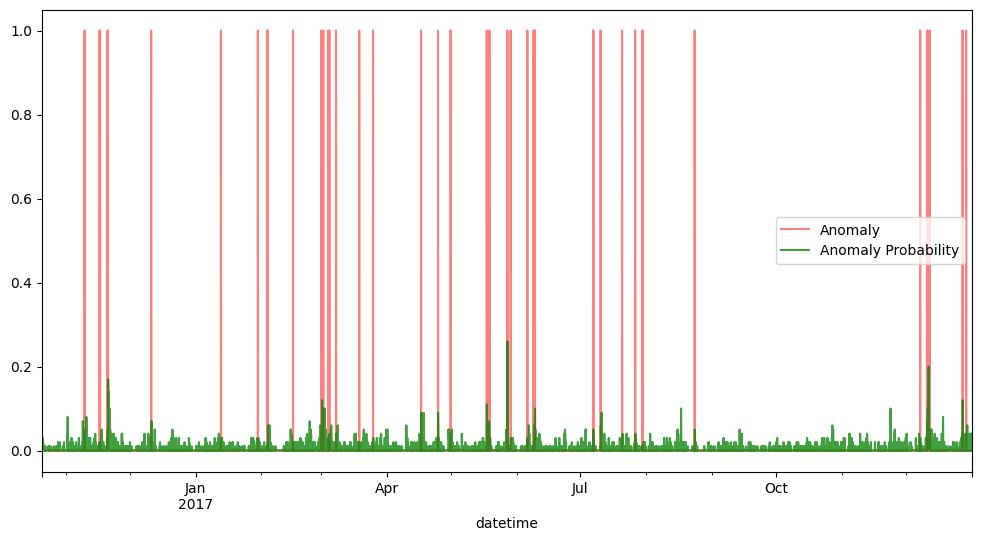

In [16]:
anomaly_prob = model.predict_proba(X_test)[:, 1]
anomaly_pred = model.predict(X_test)

anomaly_prob = pd.Series(anomaly_prob, index=y_test_01.index).rename('Anomaly Probability')
y_test_01 = y_test_01.rename('Anomaly')
ax = y_test_01.plot(legend=True,color='red', figsize=(12,6), alpha=0.5)
anomaly_prob.plot(legend=True, color='green', alpha=0.75)

/Users/vcerq/miniconda/envs/NDS_TimeSeries/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vcerq/miniconda/envs/NDS_TimeSeries/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vcerq/miniconda/envs/NDS_TimeSeries/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

<Axes: >

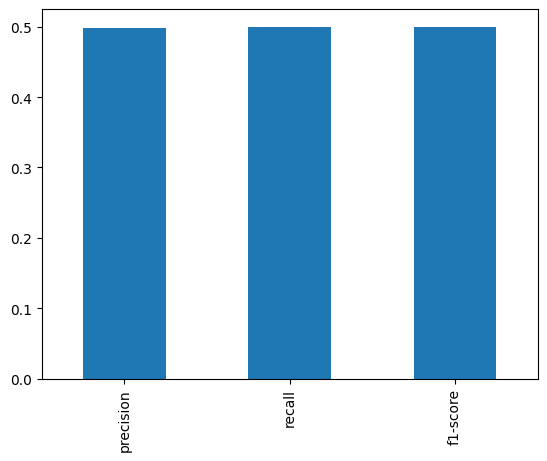

In [17]:
from sklearn.metrics import roc_auc_score, brier_score_loss, f1_score, recall_score, precision_score, classification_report

results_rf = classification_report(y_true=y_test_01, y_pred=anomaly_pred, output_dict=True)['macro avg']
results_rf.pop('support')

pd.Series(results_rf).plot.bar()

In [20]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier

X_tr_resampled, y_tr_resampled = RandomUnderSampler().fit_resample(X_train, y_train_01)

model = RandomForestClassifier()
model.fit(X_tr_resampled, y_tr_resampled)

RandomForestClassifier()

<Axes: xlabel='datetime'>

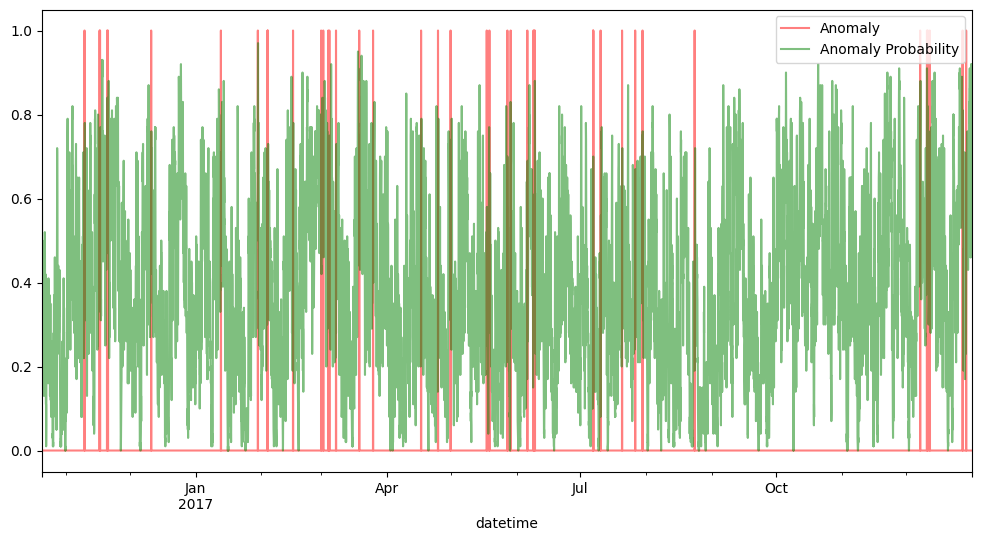

In [21]:
anomaly_prob = model.predict_proba(X_test)[:, 1]
anomaly_pred = model.predict(X_test)

anomaly_prob = pd.Series(anomaly_prob, index=y_test_01.index).rename('Anomaly Probability')
ax = y_test_01.plot(legend=True,color='red', figsize=(12,6), alpha=0.5)
anomaly_prob.plot(legend=True, color='green', alpha=0.5)

<Axes: >

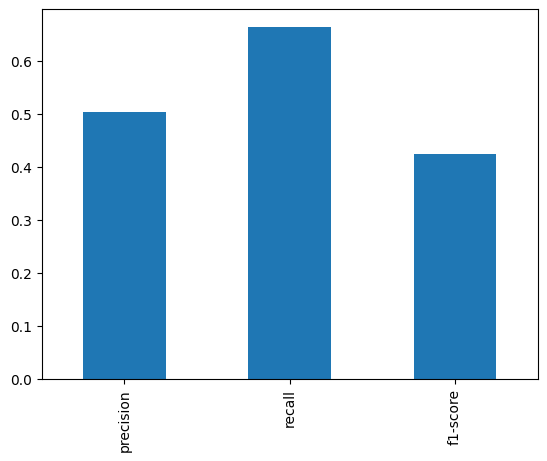

In [22]:
results_rfr = classification_report(y_true=y_test_01, y_pred=anomaly_pred, output_dict=True)['macro avg']
results_rfr.pop('support')

pd.Series(results_rfr).plot.bar()

/Users/vcerq/miniconda/envs/NDS_TimeSeries/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/vcerq/miniconda/envs/NDS_TimeSeries/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vcerq/miniconda/envs/NDS_TimeSeries/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to

<Axes: xlabel='datetime'>

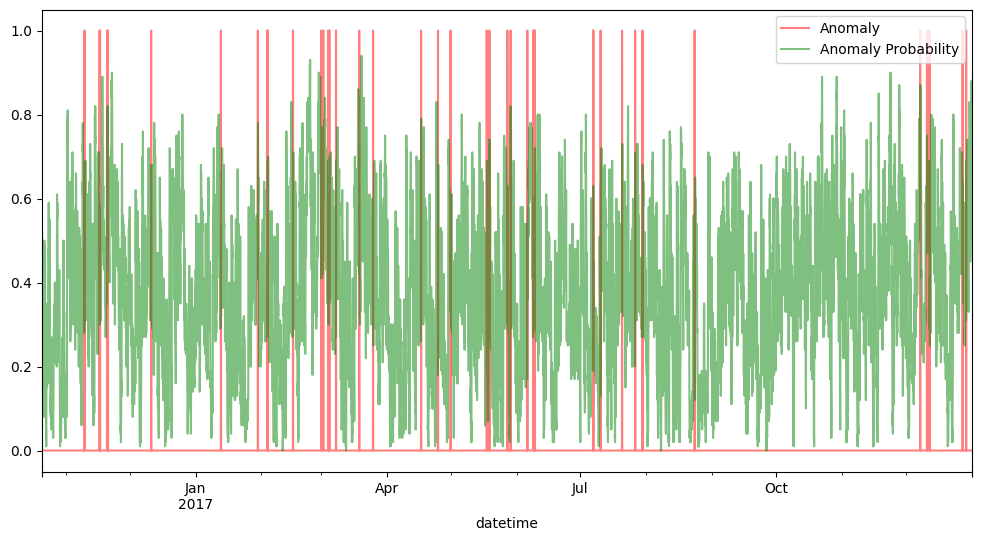

In [23]:
model = BalancedRandomForestClassifier()

model.fit(X_train, y_train_01)

anomaly_prob = model.predict_proba(X_test)[:, 1]
anomaly_pred = model.predict(X_test)

anomaly_prob = pd.Series(anomaly_prob, index=y_test_01.index).rename('Anomaly Probability')
ax = y_test_01.plot(legend=True,color='red', figsize=(12,6), alpha=0.5)
anomaly_prob.plot(legend=True, color='green', alpha=0.5)

<Axes: >

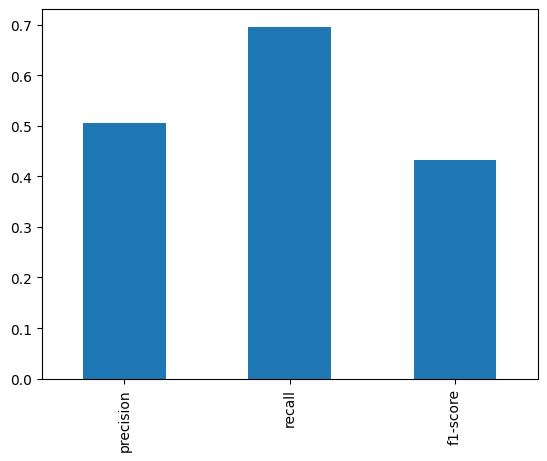

In [24]:
results_brf = classification_report(y_true=y_test_01, y_pred=anomaly_pred, output_dict=True)['macro avg']
results_brf.pop('support')

pd.Series(results_brf).plot.bar()

<Axes: >

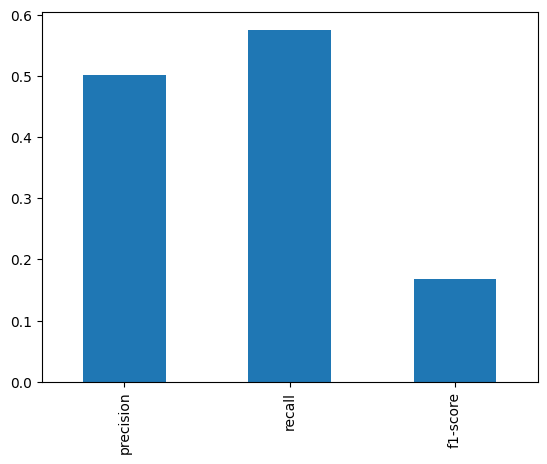

In [25]:
anomaly_pred_thr = (anomaly_prob > 0.2).astype(int)

results_thr_eg = classification_report(y_true=y_test_01, y_pred=anomaly_pred_thr, output_dict=True)['macro avg']
results_thr_eg.pop('support')

pd.Series(results_thr_eg).plot.bar()

In [26]:
from sklearn.ensemble import IsolationForest
?IsolationForest

iforest = IsolationForest(n_estimators=100, max_samples='auto')
iforest.fit(X_train)

if_pred = iforest.predict(X_test)
if_pred[if_pred == 1]=0
if_pred[if_pred == -1]=1
pd.Series(if_pred).value_counts()

0    8765
1    1731
Name: count, dtype: int64

Init signature:
IsolationForest(
    *,
    n_estimators=100,
    max_samples='auto',
    contamination='auto',
    max_features=1.0,
    bootstrap=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
)
Docstring:     
Isolation Forest Algorithm.

Return the anomaly score of each sample using the IsolationForest algorithm

The IsolationForest 'isolates' observations by randomly selecting a feature
and then randomly selecting a split value between the maximum and minimum
values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the
number of splittings required to isolate a sample is equivalent to the path
length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a
measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies.
Hence, when a forest of random trees collectively produce shorter path
len

<Axes: >

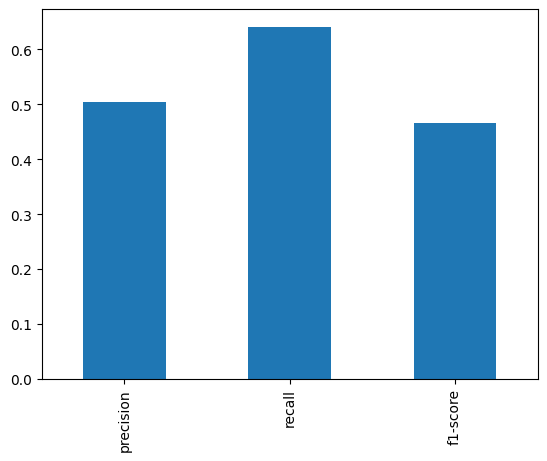

In [27]:
results_if = classification_report(y_true=y_test_01, y_pred=if_pred, output_dict=True)['macro avg']
results_if.pop('support')

pd.Series(results_if).plot.bar()

In [30]:
from pyod.models.knn import KNN 

In [31]:
model = KNN()
model.fit(X_train)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [32]:
knn_pred = model.predict(X_test)
knn_prob = model.decision_function(X_test)
knn_prob

array([0.36661803, 0.34580566, 0.34061428, ..., 0.29678581, 0.3010361 ,
       0.2566586 ])

<Axes: xlabel='datetime'>

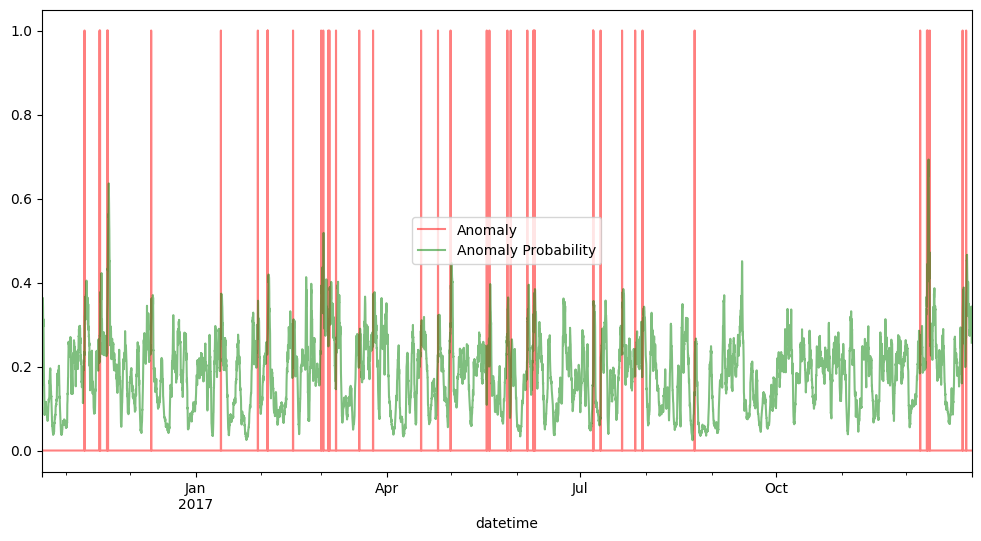

In [33]:
knn_prob = pd.Series(knn_prob, index=y_test_01.index).rename('Anomaly Probability')
ax = y_test_01.plot(legend=True,color='red', figsize=(12,6), alpha=0.5)
knn_prob.plot(legend=True, color='green', alpha=0.5)

<Axes: >

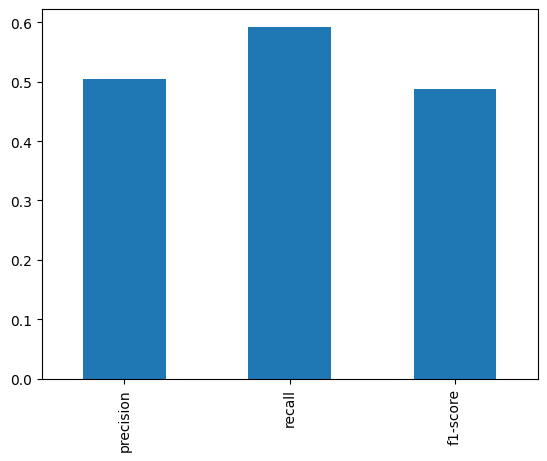

In [34]:
results_knn = classification_report(y_true=y_test_01, y_pred=knn_pred, output_dict=True)['macro avg']
results_knn.pop('support')

pd.Series(results_knn).plot.bar()

<Axes: >

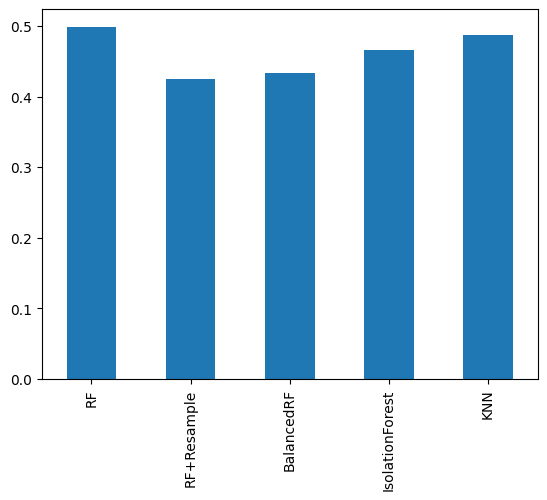

In [35]:
f1_scores = {'RF':results_rf['f1-score'],
'RF+Resample': results_rfr['f1-score'],
'BalancedRF': results_brf['f1-score'],
'IsolationForest': results_if['f1-score'],
'KNN': results_knn['f1-score']}

pd.Series(f1_scores).plot.bar()